## Assignment 01

В данном задании мы рассмотрим задачу классификации текстов. Для достижения лучших результатов воспользуемся информативными призанковыми описаниями для слов.

In [1]:
# do not change the code in the block below
# __________start of block__________
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR



from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


out_dict = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# __________end of block__________
import seaborn as sns
sns.set_theme(style='darkgrid')

### Предобработка текста и токенизация

Предобработка практически аналогична рассмотренной на лекции. Библиотека `nltk` [link](https://www.nltk.org) широко используется при обработке текстов. По ссылке выше можно найти ее развернутое описание и документацию.

In [2]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

# Small check that everything is done properly
assert texts_train[5] ==  'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
assert texts_test[74] == 'poetry in motion captured on film'
assert len(texts_test) == len(y_test)
# __________end of block__________

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


Следующие функции помогут вам с визуализацией процесса обучения сети.

In [3]:
# do not change the code in the block below
# __________start of block__________
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title(' '.join(['Loss', title_suffix]), fontsize=16)
    ax[0].plot(train_loss, lw=2, color=sns.color_palette()[0],
               label='train')
    ax[0].plot(val_loss, lw=2, color=sns.color_palette()[3],
               label='validation')
    ax[0].set_xlabel('epoch', fontsize=14)
    ax[0].set_ylabel('loss', fontsize=14)
    ax[0].legend(shadow = True, fontsize=14, loc='upper left')

    ax[1].set_title(' '.join(['Validation accuracy', title_suffix]), fontsize=16)
    ax[1].plot(train_accuracy, lw=2, color=sns.color_palette()[0],
               label='Train')
    ax[1].plot(val_accuracy, lw=2, color=sns.color_palette()[3],
               label='Validation')
    ax[1].set_xlabel('epoch', fontsize=14)
    ax[1].set_ylabel('accuracy', fontsize=14)
    ax[1].legend(shadow = True, fontsize=14, loc='upper left')
    
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')
            
        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    #plt.grid()
    return out_dict
# __________end of block__________

### Задача №1. Мешок слов.

Воспользуйтесь классическим подходом к векторизации текстов: мешком слов. Для этого можно как воспользоваться `CountVectorizer` из `sklearn`, так и самостоятельно реализовать ее. Обращаем ваше внимание, в данной задаче используется лишь `k` наиболее часто встречаемых слов из обучающей части выборки.

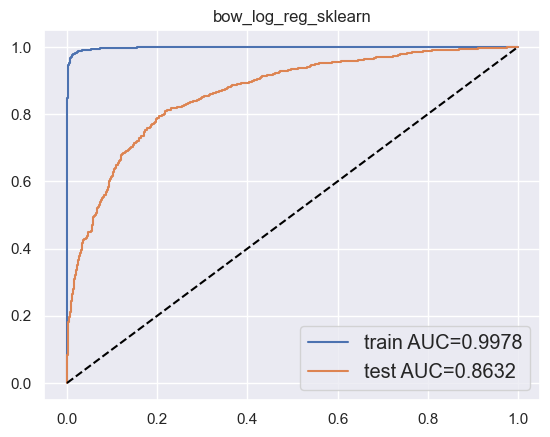

In [4]:
# do not change the code in the block below
# __________start of block__________

k = min(10000, len(set(' '.join(texts_train).split())))

counts = Counter(' '.join(texts_train).split())

bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, 'float32')

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

# Small check that everything is done properly if you are using local bow implementation
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index('!')] == texts_train[65].split().count('!')


bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(bow_model, 'bow_log_reg_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

Результаты неплохие, но явно видно переобучение. Этот вывод можно сделать судя по значительному превосходству качества (AUC ROC) на train выборке относительно test. Более того, на обучающей выборке качество стремится к единице, в то время как на отложенной – значительно ниже, т.е. модель уловила множество зависимостей, свойственных лишь обучающей выборке. Базово проблема переобучения рассматривалась в [лекции №3](https://youtu.be/Ql00acFsEhE). Более подробно она еще не раз встретится при дальнейшем прохождении курса.

В данной задаче с переобучением мы разберемся в дальнейшем. Сейчас же реализуйте решение на основе логистической регрессии, но уже используя PyTorch. В результате вам должна быть доступна обученная модель, предсказывающая вероятности для двух классов. Качество на тестовой выборке должно не уступать логистической регрессии.

In [5]:
from torch.utils.data import Dataset
class TrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        X = self.X[index]
        y = self.y[index]
        
        return X, y

In [6]:
batch_size = 32
train_dataset = TrainDataset(X_train_bow, y_train)
test_dataset = TrainDataset(X_test_bow, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Не забывайте о функциях потерь: `nn.CrossEntropyLoss` объединяет в себе `LogSoftMax` и `NLLLoss`. Также не забывайте о необходимости перенести тензоры на используемый `device`.

In [7]:
class LogReg(nn.Module):
    def __init__(self, n_inp_channels, n_out_channels):
        super().__init__()
        self.fc = nn.Linear(n_inp_channels, n_out_channels)
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [8]:
X_train_bow_torch = torch.Tensor(X_train_bow).to(device)
X_test_bow_torch = torch.Tensor(X_test_bow).to(device)

y_train_torch = torch.Tensor(y_train).to(device)
y_test_torch = torch.Tensor(y_test).to(device)

Функция ниже поможет с обучением модели. Часть кода необходимо реализовать самостоятельно.

In [9]:
def train_model(
    model,
    train_loader, 
    val_loader,
    loss,
    optimizer,
    n_epochs,
    scheduler=None,
    show_plots=True,
    print_log=True
):    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    if print_log:
        log_print = []
     
    for epoch in range(n_epochs):
        model.train()
        if show_plots or print_log:
            display.clear_output(wait=True)
            if show_plots and epoch != 0:
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
            if print_log:
                cur_print = f'Epoch {epoch+1}/{n_epochs}'
                log_print.append(cur_print)
                print('\n'.join(log_print))
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            prediction = model(x)
            loss_value = loss(prediction, y)
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value.item()
        
        train_loss = loss_accum / i_step
        train_acc = float(correct_samples) / total_samples
        val_loss, val_acc = compute_loss_acc(model, val_loader, loss)
        
        val_loss_history.append(float(val_loss))
        val_acc_history.append(float(val_acc))
        train_loss_history.append(float(train_loss))
        train_acc_history.append(float(train_acc))
        
        if print_log:
            log_print.append(f'Train loss: %f, Train acc: %f, Val loss: %f, Val acc: %f' % (round(train_loss,4), round(train_acc,4), round(val_loss,4), round(val_acc,4)))
            log_print.append('-' * 75)
        if scheduler is not None:
            scheduler.step()
    
    if show_plots or print_log:
        display.clear_output(wait=True)
        if show_plots and epoch != 0:
            plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
        if print_log:
            print('\n'.join(log_print))
    
    return model


def compute_loss_acc(model, loader, loss):

    model.eval() # Evaluation mode
    total_samples = 0
    correct_samples = 0
    loss_hist = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        prediction = model(x)
        
        total_samples += y.shape[0]
        correct_samples += torch.sum(torch.argmax(prediction, dim=1) == y).item()
        
        loss_value = loss(prediction, y).item()
        loss_hist.append(loss_value)
    
    ave_loss = np.array(loss_hist).mean()
    accuracy = correct_samples / total_samples
    return ave_loss, accuracy

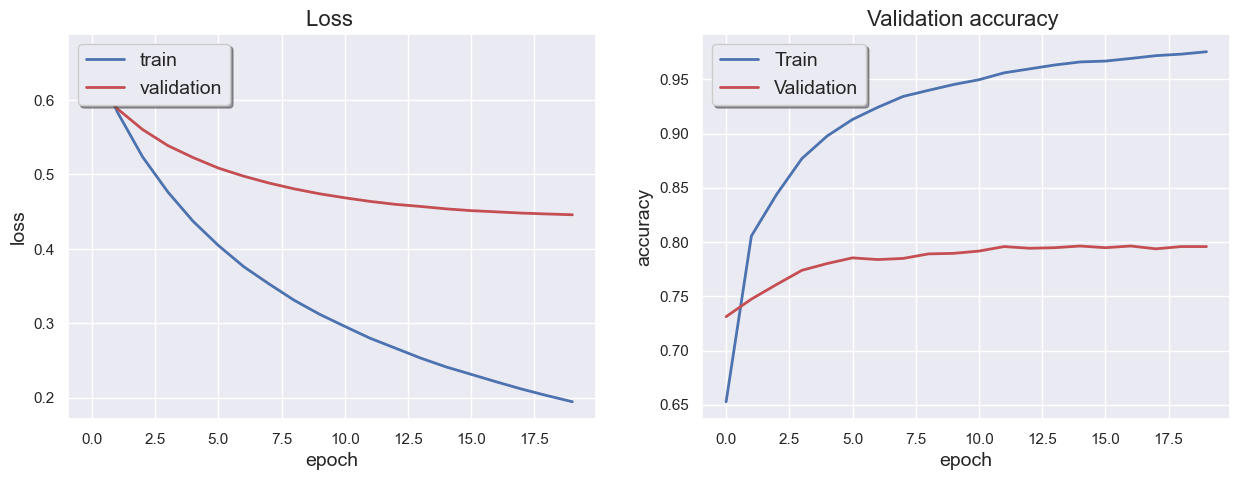

Epoch 1/20
Train loss: 0.665100, Train acc: 0.652800, Val loss: 0.628400, Val acc: 0.731200
---------------------------------------------------------------------------
Epoch 2/20
Train loss: 0.584200, Train acc: 0.805600, Val loss: 0.588500, Val acc: 0.747400
---------------------------------------------------------------------------
Epoch 3/20
Train loss: 0.523700, Train acc: 0.844000, Val loss: 0.560500, Val acc: 0.760900
---------------------------------------------------------------------------
Epoch 4/20
Train loss: 0.476500, Train acc: 0.877000, Val loss: 0.538900, Val acc: 0.774000
---------------------------------------------------------------------------
Epoch 5/20
Train loss: 0.437000, Train acc: 0.897800, Val loss: 0.522700, Val acc: 0.780200
---------------------------------------------------------------------------
Epoch 6/20
Train loss: 0.404500, Train acc: 0.913000, Val loss: 0.508600, Val acc: 0.785400
--------------------------------------------------------------------

In [10]:
try:
    del model
except:
    pass

model = LogReg(X_train_bow.shape[1], 2)
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bow_nn_model = train_model(model, train_loader, val_loader, loss, optimizer, 
                           n_epochs=20)

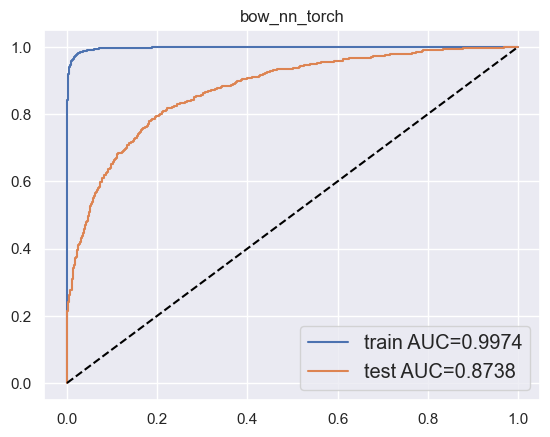

In [11]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(bow_nn_model, 'bow_nn_torch', X_train_bow_torch, X_test_bow_torch, y_train, y_test, out_dict)

assert out_dict['bow_log_reg_sklearn_test'] - out_dict['bow_nn_torch_test'] < 0.01, 'AUC ROC on test data should be close to the sklearn implementation'
# __________end of block__________

А теперь повторите процедуру обучения выше, но для различных значений `k` – размера словаря. В список results сохраните `AUC ROC` на тестовой части выборки для модели, обученной со словарем размера `k`.

In [12]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

counts = Counter(' '.join(texts_train).split())

for k in vocab_sizes_list:
    bow_vocabulary = [key for key, val in counts.most_common(k)]
    
    X_train_bow_k = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow_k = np.stack(list(map(text_to_bow, texts_test)))
    
    train_dataset_k = TrainDataset(X_train_bow_k, y_train)
    test_dataset_k = TrainDataset(X_test_bow_k, y_test)

    train_loader_k = torch.utils.data.DataLoader(train_dataset_k, 
                                           batch_size=batch_size, shuffle=True)

    val_loader_k = torch.utils.data.DataLoader(test_dataset_k, batch_size=batch_size)

    try:
        del model
    except:
        pass

    model = LogReg(X_train_bow_k.shape[1], 2)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    bow_nn_model_k = train_model(model, train_loader_k, val_loader_k, loss, optimizer, 
                               n_epochs=20, show_plots=False, print_log=False)    

    predicted_probas_on_test_for_k_sized_dict = bow_nn_model_k(torch.Tensor(X_test_bow_k).to(device)).detach().cpu().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

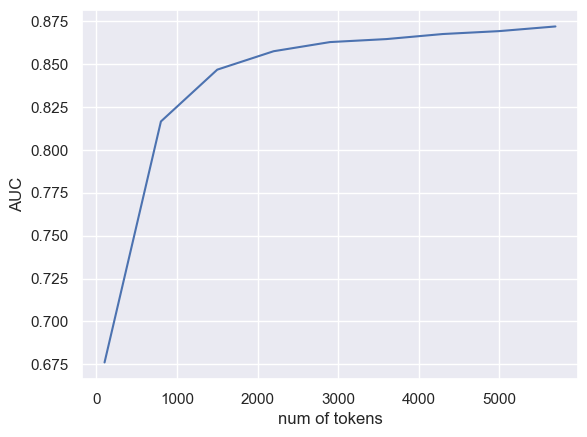

In [13]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.84, 'Best AUC ROC should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')


out_dict['bow_k_vary'] = results
# __________end of block__________

### Задача №2: Использование TF-iDF признаков.

Для векторизации текстов также можно воспользоваться TF-iDF. Это позволяет исключить из рассмотрения многие слова, не оказывающие значимого влияния при оценке непохожести текстов.

Подробнее про TF-iDF можно почитать, например, [здесь](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089).
Там же можно почитать о его самостоятельной реализации.

Ваша задача: векторизовать тексты используя TF-iDF (или `TfidfVectorizer` из `sklearn`, или реализовав его самостоятельно) и построить классификатор с помощью PyTorch, аналогичный задаче №1.

Затем также оцените качество классификации по AUC ROC для различных размеров словаря.

Качество классификации должно быть не ниже 0.86 AUC ROC.

In [14]:
from sklearn.feature_extraction import text

In [15]:
vocabulary = [key for key, val in counts.most_common()][50:]

vectorizer = text.TfidfVectorizer(vocabulary=vocabulary)


X_train_tfidf = vectorizer.fit_transform(texts_train).toarray()
X_test_tfidf = vectorizer.transform(texts_test).toarray()

train_dataset_tfidf = TrainDataset(X_train_tfidf, y_train)
test_dataset_tfidf = TrainDataset(X_test_tfidf, y_test)

train_loader_tfidf = torch.utils.data.DataLoader(train_dataset_tfidf, 
                                           batch_size=batch_size, shuffle=True)

val_loader_tfidf = torch.utils.data.DataLoader(test_dataset_tfidf, batch_size=batch_size)

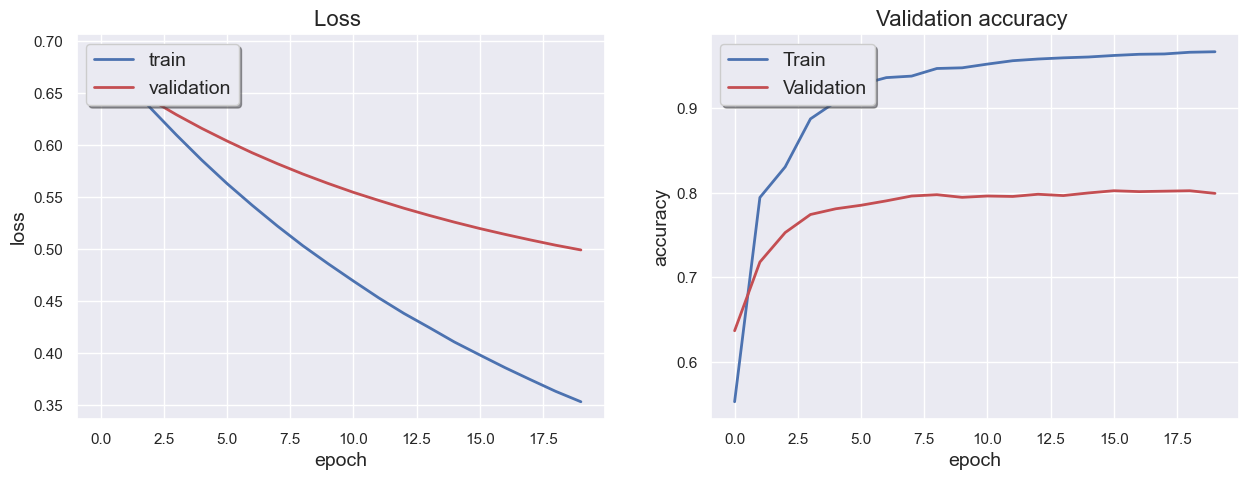

Epoch 1/20
Train loss: 0.689900, Train acc: 0.553000, Val loss: 0.675200, Val acc: 0.637000
---------------------------------------------------------------------------
Epoch 2/20
Train loss: 0.662100, Train acc: 0.794600, Val loss: 0.658700, Val acc: 0.718200
---------------------------------------------------------------------------
Epoch 3/20
Train loss: 0.635100, Train acc: 0.830800, Val loss: 0.643600, Val acc: 0.753100
---------------------------------------------------------------------------
Epoch 4/20
Train loss: 0.609800, Train acc: 0.887600, Val loss: 0.629300, Val acc: 0.774500
---------------------------------------------------------------------------
Epoch 5/20
Train loss: 0.585700, Train acc: 0.907800, Val loss: 0.616200, Val acc: 0.781200
---------------------------------------------------------------------------
Epoch 6/20
Train loss: 0.563100, Train acc: 0.928400, Val loss: 0.604000, Val acc: 0.785400
--------------------------------------------------------------------

In [16]:
try:
    del model
except:
    pass

model = LogReg(X_train_tfidf.shape[1], 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_tf_idf = train_model(model, train_loader_tfidf, val_loader_tfidf, loss, optimizer, 
                               n_epochs=20)  

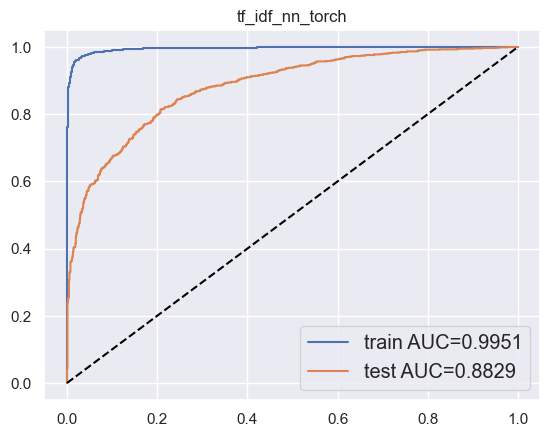

In [17]:
# do not change the code in the block below
X_train_tfidf_torch = torch.Tensor(X_train_tfidf).to(device)
X_test_tfidf_torch = torch.Tensor(X_test_tfidf).to(device)
# __________start of block__________
out_dict = visualize_and_save_results(model_tf_idf, 'tf_idf_nn_torch', X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, out_dict)

assert out_dict['tf_idf_nn_torch_test'] >= out_dict['bow_nn_torch_test'], 'AUC ROC on test data should be better or close to BoW for TF-iDF features'
# __________end of block__________

Аналогично задаче №1 повторите процедуру обучения для различных значений `k` – размера словаря и сохраните `AUC ROC` на тестовой части выборки в список `results`.

In [18]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:
    
    vocabulary_k = [key for key, val in counts.most_common(k)]
    vectorizer_k = text.TfidfVectorizer(vocabulary=vocabulary_k)

    X_train_tfidf_k = vectorizer_k.fit_transform(texts_train).toarray()
    X_test_tfidf_k = vectorizer_k.transform(texts_test).toarray()

    train_dataset_tfidf_k = TrainDataset(X_train_tfidf_k, y_train)
    test_dataset_tfidf_k = TrainDataset(X_test_tfidf_k, y_test)

    train_loader_tfidf_k = torch.utils.data.DataLoader(train_dataset_tfidf_k, 
                                           batch_size=batch_size, shuffle=True)

    val_loader_tfidf_k = torch.utils.data.DataLoader(test_dataset_tfidf_k, batch_size=batch_size)
    
    try:
        del model
    except:
        pass

    model = LogReg(X_train_tfidf_k.shape[1], 2)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model_tf_idf_k = train_model(model, train_loader_tfidf_k, val_loader_tfidf_k, loss, optimizer, 
                               n_epochs=20, show_plots=False, print_log=False)  

    predicted_probas_on_test_for_k_sized_dict = model_tf_idf_k(torch.Tensor(X_test_tfidf_k).to(device)).detach().cpu().numpy()[:, 1]
    
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

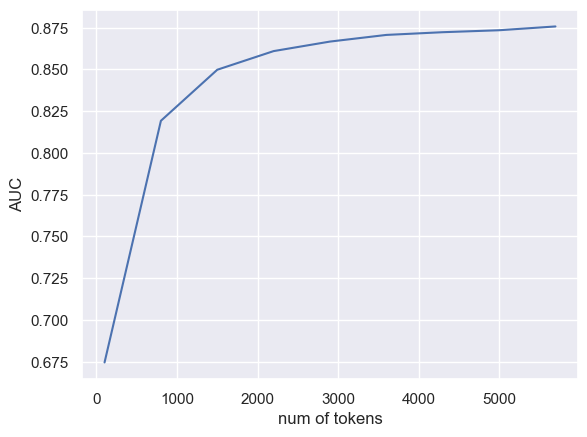

In [19]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.85, 'Best AUC ROC for TF-iDF should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')

out_dict['tf_idf_k_vary'] = results
# __________end of block__________

### Задача №3: Сравнение с Наивным Байесовским классификатором.

Классические модели все еще способны показать хороший результат во многих задачах. Обучите наивный байесовский классификатор на текстах, векторизованных с помощью BoW и TF-iDF и сравните результаты с моделями выше.

*Комментарий: обращаем ваше внимание, необходимо выбрать подходящее к данной задаче априорное распределение для признаков, т.е. выбрать верную версию классификатора из `sklearn`: `GaussianNB`, `MultinomialNB`, `ComplementNB`, `BernoulliNB`, `CategoricalNB`*

In [20]:
from sklearn.naive_bayes import BernoulliNB

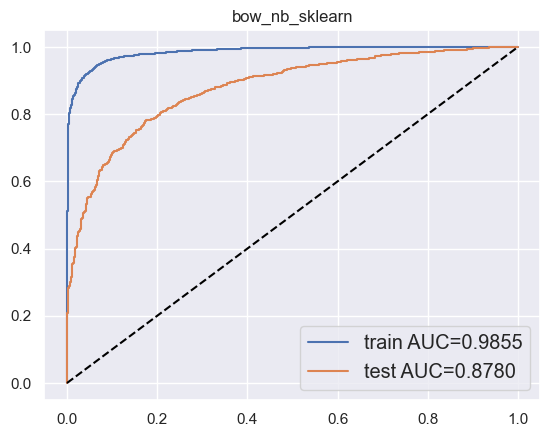

In [21]:
clf_nb_bow = BernoulliNB()
clf_nb_bow.fit(X_train_bow, y_train)

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

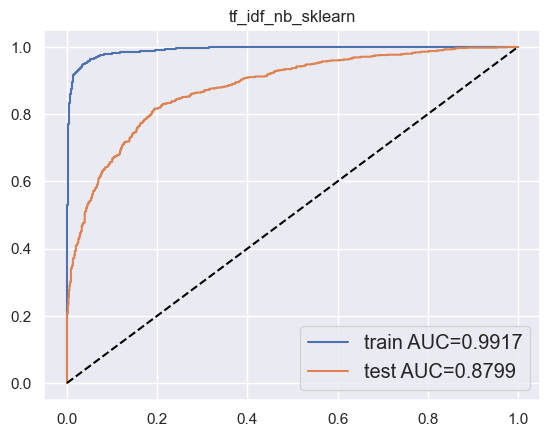

In [22]:
clf_nb_tfidf = BernoulliNB()
clf_nb_tfidf.fit(X_train_tfidf, y_train)

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)
# __________end of block__________

In [23]:
# do not change the code in the block below
# __________start of block__________
assert out_dict['tf_idf_nb_sklearn_test'] > out_dict['bow_nb_sklearn_test'],' TF-iDF results should be better'
assert out_dict['tf_idf_nb_sklearn_test'] > 0.86, 'TF-iDF Naive Bayes score should be above 0.86'
# __________end of block__________

### Задача №4: Использование предобученных эмбеддингов

Наконец, воспользуемся предобученными эмбеддингами из библиотеки `gensim`. В нем доступно несколько эмбеддингов, предобученных на различных корпусах текстов. Полный список можно найти [здесь](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). Напоминаем, что лучше использовать те эмбеддинги, которые были обучены на текстах похожей структуры.

Ваша задача: обучить модель (достаточно логистической регрессии или же двуслойной неронной сети), используя усредненный эмбеддинг для всех токенов в отзыве, добиться качества не хуже, чем с помощью BoW/TF-iDF и снизить степень переобучения (разницу между AUC ROC на обучающей и тестовой выборках).

In [24]:
import gensim.downloader as api
gensim_embedding_model = api.load('word2vec-google-news-300')

In [25]:
def text_to_average_embedding(text, gensim_embedding_model):
    embedding_for_text = np.zeros(gensim_embedding_model[0].shape)
    l = len(text.split())
    for word in text.split():
        if word in gensim_embedding_model:
            embedding_for_text += gensim_embedding_model[word]
        else:
            l -= 1 
            
    return embedding_for_text / l if l != 0 else embedding_for_text

In [26]:
X_train_emb = np.array([text_to_average_embedding(text, gensim_embedding_model) for text in texts_train])
X_test_emb = np.array([text_to_average_embedding(text, gensim_embedding_model) for text in texts_test])

assert len(X_train_emb[0]) == gensim_embedding_model.vector_size, 'Seems like the embedding shape is wrong'

In [27]:
X_train_emb_torch = torch.Tensor(X_train_emb).to(device)
X_test_emb_torch = torch.Tensor(X_test_emb).to(device)

y_train_torch = torch.Tensor(y_train).to(device)
y_test_torch = torch.Tensor(y_test).to(device)

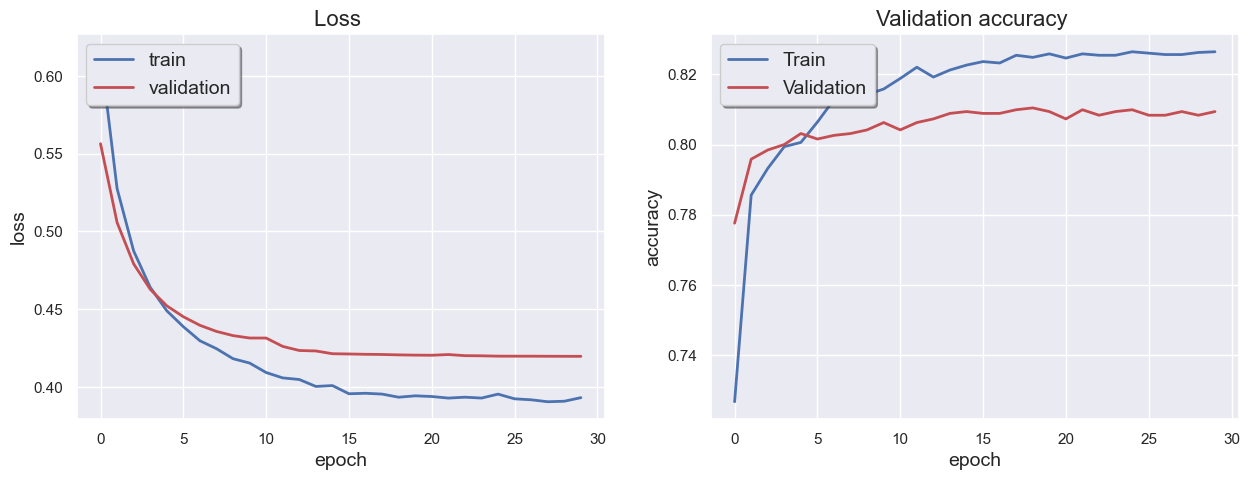

Epoch 1/30
Train loss: 0.615600, Train acc: 0.726800, Val loss: 0.556400, Val acc: 0.777600
---------------------------------------------------------------------------
Epoch 2/30
Train loss: 0.527600, Train acc: 0.785600, Val loss: 0.505800, Val acc: 0.795800
---------------------------------------------------------------------------
Epoch 3/30
Train loss: 0.487500, Train acc: 0.793200, Val loss: 0.479200, Val acc: 0.798400
---------------------------------------------------------------------------
Epoch 4/30
Train loss: 0.464100, Train acc: 0.799400, Val loss: 0.462800, Val acc: 0.800000
---------------------------------------------------------------------------
Epoch 5/30
Train loss: 0.449000, Train acc: 0.800600, Val loss: 0.452200, Val acc: 0.803100
---------------------------------------------------------------------------
Epoch 6/30
Train loss: 0.438800, Train acc: 0.806400, Val loss: 0.445200, Val acc: 0.801600
--------------------------------------------------------------------

In [28]:
train_dataset_emb = TrainDataset(X_train_emb, y_train)
test_dataset_emb = TrainDataset(X_test_emb, y_test)
train_loader_emb = torch.utils.data.DataLoader(train_dataset_emb, batch_size=batch_size, shuffle=True)
val_loader_emb = torch.utils.data.DataLoader(test_dataset_emb, batch_size=batch_size)

try:
    del model
except:
    pass

model = LogReg(X_train_emb.shape[1], 2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
loss = nn.CrossEntropyLoss()
scheduler = MultiStepLR(optimizer, milestones=[15, 25], gamma=0.2)

model_emb = train_model(model, train_loader_emb, val_loader_emb, loss, optimizer, 
                               n_epochs=30, scheduler=scheduler)

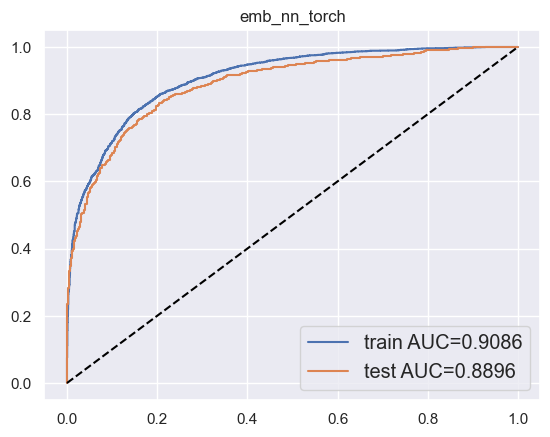

In [29]:
# do not change the code in the block below
# __________start of block__________

out_dict = visualize_and_save_results(model, 'emb_nn_torch', X_train_emb_torch, X_test_emb_torch, y_train, y_test, out_dict)
assert out_dict['emb_nn_torch_test'] > 0.87, 'AUC ROC on test data should be better than 0.86'
assert out_dict['emb_nn_torch_train'] - out_dict['emb_nn_torch_test'] < 0.1, 'AUC ROC on test and train data should not be different more than by 0.1'
# __________end of block__________

### Сдача задания
Запустите код ниже для генерации посылки и сдайте на проверку файл `submission_dict_101.npy`.

In [30]:
# do not change the code in the block below
# __________start of block__________

np.save('submission_dict_101.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_101.npy`')
# __________end of block__________

File saved to `submission_dict_101.npy`
